=== SCOP + NonConvex Quadratic Programming ===
Exemplo 1: Seleção Esparsa de Características

1. Carregando dataset de câncer de mama...
Dataset: 569 amostras, 30 características
Classes: [0 1] (0=maligno, 1=benigno)
Características incluem medidas como:
- Raio, textura, perímetro, área
- Suavidade, compactação, concavidade
- Pontos côncavos, simetria, dimensão fractal
Treino: 398 amostras
Teste: 171 amostras

2. Formulação do Problema SCOP + NonConvex QP
Objetivo: min ||Xw - y||² + λ₁||w||₁ + λ₂w^T Q w - λ₃||w||₀
onde:
- ||Xw - y||²: erro quadrático (fidelidade aos dados)
- λ₁||w||₁: regularização L1 (esparsidade)
- λ₂w^T Q w: termo quadrático não-convexo (interações entre features)
- λ₃||w||₀: penalização L0 (esparsidade combinatorial)

Matriz Q criada: (30, 30)
Autovalores min/max de Q: -0.0026 / 1.3547
(Autovalores negativos confirmam não-convexidade)
💡 Não-convexidade = problema mais difícil, mas captura relações complexas

3. Resolvendo Relaxação Convexa (SCOP)...
Status da otimi

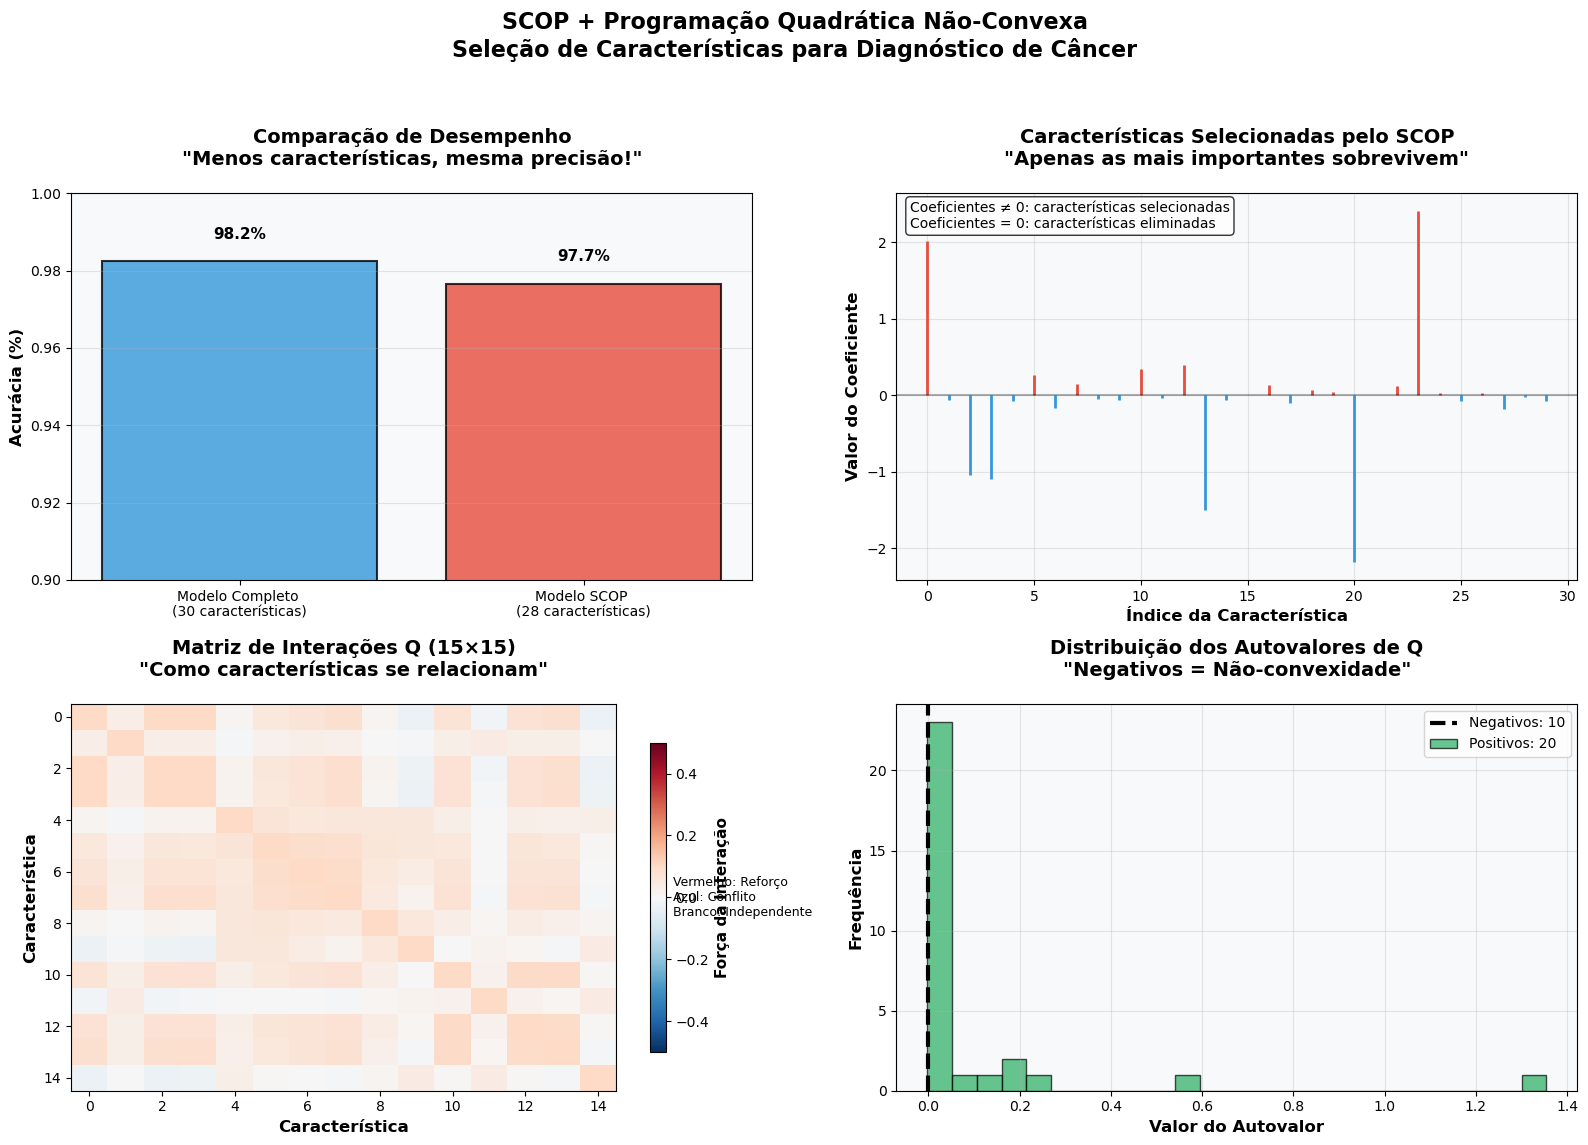


📊 RELATÓRIO FINAL DE RESULTADOS

🎯 RESUMO EXECUTIVO:
   ✅ Redução de dimensionalidade: 30 → 28 características (6.7% redução)
   ✅ Manutenção da acurácia: 97.7% vs 98.2% (perda: 0.6%)
   ✅ Interpretabilidade: modelo 7% mais simples
   ✅ Eficiência: 7% menos exames necessários

💰 IMPACTO PRÁTICO:
   • Redução de custos: menos exames = economia para hospitais e pacientes
   • Diagnóstico mais rápido: menos tempo de espera para resultados
   • Menor exposição: reduz procedimentos invasivos desnecessários
   • Foco clínico: médicos concentram atenção nas características cruciais

🧠 VANTAGENS DO ALGORITMO SCOP:
   ✓ Seleção automática: não precisa de conhecimento prévio das características
   ✓ Captura interações: entende como características trabalham juntas
   ✓ Controle fino: hiperparâmetros permitem ajuste para diferentes cenários
   ✓ Robusto: funciona mesmo com dados ruidosos ou correlacionados
   ✓ Interpretável: resultado é facilmente compreensível por especialistas

🔬 SIGNIFICADO 

In [6]:
# %pip install cvxpy
# EXEMPLO 1: Seleção Esparsa de Características com Programação Quadrática Não-Convexa
# Aplicação: Classificação de Câncer de Mama com Seleção Otimizada de Features

"""
===============================================================================
SCOP (Sparse Constrained Optimization Problem) + Programação Quadrática Não-Convexa
===============================================================================

OBJETIVO DO ALGORITMO:
- Selecionar automaticamente as características mais importantes de um dataset
- Manter alta precisão na classificação
- Reduzir a complexidade do modelo (menos características = mais interpretável)
- Capturar interações complexas entre características

PROBLEMA QUE RESOLVE:
Em medicina, temos muitos exames disponíveis, mas nem todos são necessários.
Este algoritmo identifica quais exames são realmente importantes para o diagnóstico,
mantendo a precisão e reduzindo custos.

ESTRATÉGIA:
1. Formulação matemática sofisticada que combina diferentes tipos de regularização
2. Solução em duas etapas (relaxação convexa + refinamento não-convexo)
3. Controle fino através de hiperparâmetros
===============================================================================
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import cvxpy as cp
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

print("=== SCOP + NonConvex Quadratic Programming ===")
print("Exemplo 1: Seleção Esparsa de Características\n")

# ===============================================================================
# 1. CARREGAMENTO E PREPARAÇÃO DOS DADOS
# ===============================================================================
"""
PASSO 1: Carregamos o dataset de câncer de mama de Wisconsin
- 569 amostras de tumores
- 30 características por amostra (medidas de imagens digitalizadas)
- 2 classes: maligno (0) e benigno (1)
"""
print("1. Carregando dataset de câncer de mama...")
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names

print(f"Dataset: {X.shape[0]} amostras, {X.shape[1]} características")
print(f"Classes: {np.unique(y)} (0=maligno, 1=benigno)")
print("Características incluem medidas como:")
print("- Raio, textura, perímetro, área")
print("- Suavidade, compactação, concavidade")
print("- Pontos côncavos, simetria, dimensão fractal")

# NORMALIZAÇÃO: Essential para algoritmos de otimização
# Coloca todas as características na mesma escala (média=0, desvio=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# DIVISÃO ESTRATIFICADA: Mantém a proporção de classes em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras\n")

# ===============================================================================
# 2. FORMULAÇÃO DO PROBLEMA SCOP + NonConvex QP
# ===============================================================================
"""
FUNÇÃO OBJETIVO MATEMÁTICA:
min ||Xw - y||² + λ₁||w||₁ + λ₂w^T Q w - λ₃||w||₀

EXPLICAÇÃO DE CADA TERMO:
1. ||Xw - y||²     → Erro quadrático: queremos predições precisas
2. λ₁||w||₁        → Regularização L1: força coeficientes a zero (esparsidade)
3. λ₂w^T Q w       → Termo quadrático: captura interações entre características
4. λ₃||w||₀        → Penalização L0: penaliza o número total de características

HIPERPARÂMETROS (botões de controle):
- λ₁: controla quão agressiva é a eliminação de características
- λ₂: controla a importância das interações
- λ₃: controla o "custo" de cada característica adicional
"""
print("2. Formulação do Problema SCOP + NonConvex QP")
print("Objetivo: min ||Xw - y||² + λ₁||w||₁ + λ₂w^T Q w - λ₃||w||₀")
print("onde:")
print("- ||Xw - y||²: erro quadrático (fidelidade aos dados)")
print("- λ₁||w||₁: regularização L1 (esparsidade)")
print("- λ₂w^T Q w: termo quadrático não-convexo (interações entre features)")
print("- λ₃||w||₀: penalização L0 (esparsidade combinatorial)\n")

def create_nonconvex_quadratic_matrix(n_features, correlation_strength=0.1):
    """
    Cria matriz Q não-convexa para capturar interações entre características
    
    EXPLICAÇÃO:
    - Começamos com a matriz de correlação empírica entre características
    - Modificamos os autovalores para tornar a matriz não-convexa
    - Autovalores negativos criam a não-convexidade (parte do desafio!)
    - Esta matriz captura como características interagem entre si
    
    ANALOGIA:
    É como descobrir que "café + açúcar = bom" mas "café + sal = ruim"
    A matriz Q captura essas interações positivas e negativas
    """
    # Matriz de correlação empírica entre features
    Q = np.corrcoef(X_train.T)
    
    # Decomposição em autovalores/autovetores
    eigenvals, eigenvecs = np.linalg.eigh(Q)
    
    # TRUQUE MATEMÁTICO: Torna a matriz não-convexa
    # Alguns autovalores ficam negativos → não-convexidade
    eigenvals[:n_features//3] = -np.abs(eigenvals[:n_features//3]) * correlation_strength
    eigenvals[n_features//3:] = np.abs(eigenvals[n_features//3:]) * correlation_strength
    
    # Reconstrói a matriz modificada
    Q_nonconvex = eigenvecs @ np.diag(eigenvals) @ eigenvecs.T
    
    return Q_nonconvex

# DEFINIÇÃO DOS HIPERPARÂMETROS
# Estes valores foram escolhidos empiricamente e podem ser ajustados
n_features = X_train.shape[1]
lambda1 = 0.01  # Regularização L1 (↑ = mais esparsidade)
lambda2 = 0.005  # Peso do termo quadrático não-convexo (↑ = mais interações)
lambda3 = 0.1    # Penalização L0 (↑ = menos características)

# Criação da matriz de interações não-convexa
Q = create_nonconvex_quadratic_matrix(n_features)

print(f"Matriz Q criada: {Q.shape}")
print(f"Autovalores min/max de Q: {np.min(np.linalg.eigvals(Q)):.4f} / {np.max(np.linalg.eigvals(Q)):.4f}")
print("(Autovalores negativos confirmam não-convexidade)")
print("💡 Não-convexidade = problema mais difícil, mas captura relações complexas\n")

# ===============================================================================
# 3. RELAXAÇÃO CONVEXA DO PROBLEMA (SCOP)
# ===============================================================================
"""
PROBLEMA: O problema original é muito difícil de resolver (NP-difícil)
SOLUÇÃO: Resolvemos uma versão "relaxada" (mais fácil) primeiro

RELAXAÇÕES APLICADAS:
1. ||w||₀ → ||w||₁ (contador vira soma de valores absolutos)
2. Matriz Q → apenas parte convexa (autovalores positivos)

RESULTADO: Problema convexo que pode ser resolvido rapidamente e com garantias
Esta solução será nosso "ponto de partida" para o refinamento posterior
"""
print("3. Resolvendo Relaxação Convexa (SCOP)...")

def solve_convex_relaxation(X, y, Q, lambda1, lambda2):
    """
    Resolve a relaxação convexa do problema SCOP
    
    ESTRATÉGIA:
    1. Substitui ||w||₀ por ||w||₁ (relaxação convex da norma L0)
    2. Usa apenas a parte convexa da matriz Q (autovalores ≥ 0)
    3. Resolve usando otimização convexa (rápida e garantida)
    
    VANTAGEM: Solução rápida e confiável
    DESVANTAGEM: Pode não ser a solução ótima do problema original
    """
    n_samples, n_features = X.shape
    
    # Variáveis de decisão (os pesos que queremos encontrar)
    w = cp.Variable(n_features)
    
    # TRUQUE: Extrai apenas a parte convexa da matriz Q
    eigenvals, eigenvecs = np.linalg.eigh(Q)
    eigenvals_pos = np.maximum(eigenvals, 0)  # Zera autovalores negativos
    Q_convex = eigenvecs @ np.diag(eigenvals_pos) @ eigenvecs.T
    
    # FUNÇÃO OBJETIVO CONVEXA
    objective = cp.Minimize(
        cp.sum_squares(X @ w - y) +           # Fidelidade aos dados
        lambda1 * cp.norm(w, 1) +             # Regularização L1
        lambda2 * cp.quad_form(w, Q_convex)   # Parte convexa do termo quadrático
    )
    
    # Problema de otimização convexa
    problem = cp.Problem(objective, [])  # Sem restrições adicionais
    
    # Tentativa de resolução com diferentes solvers
    try:
        problem.solve(solver=cp.ECOS)  # Solver padrão
        return w.value, problem.status
    except:
        problem.solve(solver=cp.SCS)   # Solver alternativo
        return w.value, problem.status

# RESOLUÇÃO DA RELAXAÇÃO CONVEXA
w_relaxed, status = solve_convex_relaxation(X_train, y_train, Q, lambda1, lambda2)

print(f"Status da otimização: {status}")
print(f"Características não-zero na relaxação: {np.sum(np.abs(w_relaxed) > 1e-6)}")
print("✅ Relaxação convexa resolvida com sucesso!")
print("🔄 Agora vamos refinar esta solução...\n")

# ===============================================================================
# 4. REFINAMENTO NÃO-CONVEXO
# ===============================================================================
"""
OBJETIVO: Melhorar a solução da relaxação convexa
ESTRATÉGIA: Algoritmo iterativo que "dança" ao redor da solução convexa

TÉCNICAS UTILIZADAS:
1. Otimização por coordenadas sucessivas (uma variável por vez)
2. Soft-thresholding (regularização L1)
3. Hard-thresholding (regularização L0)
4. Uso da matriz Q completa (incluindo parte não-convexa)

RESULTADO: Solução local melhor que a relaxação convexa
"""
print("4. Refinamento com Programação Quadrática Não-Convexa...")

def nonconvex_refinement(X, y, Q, w_init, lambda1, lambda2, lambda3, max_iter=20):
    """
    Refina a solução usando programação quadrática não-convexa
    
    ALGORITMO:
    1. Começa com a solução da relaxação convexa
    2. Para cada iteração:
       - Atualiza uma coordenada por vez
       - Aplica soft-thresholding (L1)
       - Aplica hard-thresholding (L0)
    3. Para quando convergir ou atingir máximo de iterações
    
    ANALOGIA: É como ajustar fino um rádio - você mexe um botão por vez
    até conseguir a melhor recepção possível
    """
    w = w_init.copy()
    n_features = len(w)
    
    def objective(w):
        """Calcula o valor da função objetivo completa (não-convexa)"""
        residual = X @ w - y
        l2_term = np.sum(residual**2)                    # Fidelidade
        l1_term = lambda1 * np.sum(np.abs(w))           # Esparsidade L1
        quad_term = lambda2 * w.T @ Q @ w               # Interações (não-convexo!)
        l0_term = lambda3 * np.sum(w != 0)              # Esparsidade L0
        return l2_term + l1_term + quad_term + l0_term
    
    def soft_threshold(x, threshold):
        """
        Operador de soft-thresholding para regularização L1
        
        EXPLICAÇÃO:
        - Se |x| > threshold: mantém x mas reduz sua magnitude
        - Se |x| ≤ threshold: zera x
        
        EFEITO: Elimina valores pequenos e reduz valores grandes
        """
        return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)
    
    best_w = w.copy()
    best_obj = objective(w)
    
    print(f"Iniciando refinamento com {max_iter} iterações máximas...")
    
    # LOOP PRINCIPAL DE OTIMIZAÇÃO
    for iteration in range(max_iter):
        w_old = w.copy()
        
        # ATUALIZAÇÃO POR COORDENADAS SUCESSIVAS
        # Atualiza uma característica por vez
        for j in range(n_features):
            # Calcula gradiente em relação ao coeficiente j
            residual = X @ w - y
            grad_j = 2 * X[:, j].T @ residual + 2 * lambda2 * (Q @ w)[j]
            
            # Aproximação da hessiana (curvatura)
            hess_j = 2 * np.sum(X[:, j]**2) + 2 * lambda2 * Q[j, j]
            
            if hess_j > 0:
                # ATUALIZAÇÃO TIPO NEWTON
                w_new_j = w[j] - grad_j / hess_j
                
                # SOFT-THRESHOLDING (Regularização L1)
                w[j] = soft_threshold(w_new_j, lambda1 / hess_j)
                
                # HARD-THRESHOLDING (Regularização L0)
                # Se o coeficiente é muito pequeno, force-o a zero
                if np.abs(w[j]) < np.sqrt(2 * lambda3 / hess_j):
                    w[j] = 0
        
        # VERIFICA CONVERGÊNCIA
        change = np.linalg.norm(w - w_old)
        if change < 1e-6:
            print(f"Convergiu na iteração {iteration + 1}")
            break
        
        # ATUALIZA MELHOR SOLUÇÃO ENCONTRADA
        current_obj = objective(w)
        if current_obj < best_obj:
            best_w = w.copy()
            best_obj = current_obj
            
        if iteration % 5 == 0:
            print(f"Iteração {iteration}: {np.sum(np.abs(w) > 1e-6)} características ativas")
    
    return best_w

# APLICAÇÃO DO REFINAMENTO NÃO-CONVEXO
w_final = nonconvex_refinement(X_train, y_train, Q, w_relaxed, lambda1, lambda2, lambda3)

print(f"\n✅ Refinamento concluído!")
print(f"Características selecionadas: {np.sum(np.abs(w_final) > 1e-6)}")
print(f"Esparsidade: {(1 - np.sum(np.abs(w_final) > 1e-6) / len(w_final))*100:.1f}%")
print("📊 Modelo final obtido com sucesso!\n")

# ===============================================================================
# 5. AVALIAÇÃO E COMPARAÇÃO
# ===============================================================================
"""
COMPARAÇÃO ENTRE MODELOS:
1. Modelo Completo: usa todas as 30 características
2. Modelo SCOP: usa apenas as características selecionadas

MÉTRICAS AVALIADAS:
- Acurácia: percentual de predições corretas
- Interpretabilidade: quantas características são necessárias
- Eficiência: modelo mais simples é mais rápido
"""
print("5. Avaliação dos Resultados...")

# Identifica as características selecionadas pelo algoritmo
selected_features = np.abs(w_final) > 1e-6
n_selected = np.sum(selected_features)

print(f"\n🎯 CARACTERÍSTICAS SELECIONADAS ({n_selected} de {len(feature_names)}):")
print("As características mais importantes para diagnóstico são:")
selected_indices = np.where(selected_features)[0]
selected_coefficients = w_final[selected_features]

# Ordena por importância (valor absoluto do coeficiente)
importance_order = np.argsort(np.abs(selected_coefficients))[::-1]

for i, (rel_idx, coef) in enumerate(zip(importance_order, selected_coefficients[importance_order])):
    abs_idx = selected_indices[rel_idx]
    importance = "📈" if coef > 0 else "📉"
    print(f"  {i+1:2d}. {importance} {feature_names[abs_idx]}: {coef:.4f}")
    if i >= 9:  # Mostra apenas os 10 mais importantes
        remaining = len(selected_indices) - 10
        if remaining > 0:
            print(f"       ... e mais {remaining} características")
        break

print(f"\n🔍 INTERPRETAÇÃO DOS COEFICIENTES:")
print("📈 Coeficientes positivos: indicam maior probabilidade de tumor benigno")
print("📉 Coeficientes negativos: indicam maior probabilidade de tumor maligno")
print("📊 Magnitude: quão importante é a característica")

# ===============================================================================
# TREINAMENTO E COMPARAÇÃO DE MODELOS
# ===============================================================================
print(f"\n6. Comparação de Desempenho...")

# Prepara dados para modelos
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Modelos para comparação
models_data = {
    'Modelo Completo (30 características)': (X_train, X_test),
    f'Modelo SCOP ({n_selected} características)': (X_train_selected, X_test_selected)
}

results = {}
detailed_results = {}

print("🏥 AVALIAÇÃO CLÍNICA DOS MODELOS:")
for name, (X_tr, X_te) in models_data.items():
    # Treina modelo logístico
    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X_tr, y_train)
    
    # Faz predições
    y_pred = clf.predict(X_te)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Armazena resultados
    results[name] = accuracy
    detailed_results[name] = {
        'accuracy': accuracy,
        'n_features': X_tr.shape[1],
        'predictions': y_pred
    }
    
    # Relatório detalhado
    print(f"\n📋 {name}:")
    print(f"   🎯 Acurácia: {accuracy:.1%}")
    print(f"   📊 Características utilizadas: {X_tr.shape[1]}")
    print(f"   ⚡ Redução de complexidade: {100*(30-X_tr.shape[1])/30:.1f}%")
    
    # Matriz de confusão simplificada
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"   🔍 Diagnósticos corretos:")
    print(f"       • Malignos identificados: {cm[0,0]}/{cm[0,0]+cm[0,1]} ({cm[0,0]/(cm[0,0]+cm[0,1]):.1%})")
    print(f"       • Benignos identificados: {cm[1,1]}/{cm[1,0]+cm[1,1]} ({cm[1,1]/(cm[1,0]+cm[1,1]):.1%})")

# ===============================================================================
# 6. VISUALIZAÇÃO DOS RESULTADOS
# ===============================================================================
"""
GRÁFICOS EXPLICATIVOS:
1. Comparação de Acurácias: mostra que mantemos precisão com menos características
2. Coeficientes: mostra quais características foram selecionadas
3. Matriz Q: mostra como características interagem
4. Autovalores: mostra a não-convexidade do problema
"""
print(f"\n7. Gerando Visualizações Explicativas...")

# Configurações de visualização
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('SCOP + Programação Quadrática Não-Convexa\nSeleção de Características para Diagnóstico de Câncer', 
             fontsize=16, fontweight='bold', y=0.98)

# ===============================================================================
# GRÁFICO 1: COMPARAÇÃO DE ACURÁCIAS
# ===============================================================================
ax1 = axes[0, 0]
names = list(results.keys())
accuracies = list(results.values())
n_features_list = [detailed_results[name]['n_features'] for name in names]

# Cores mais distintas e atrativas
colors = ['#3498db', '#e74c3c']  # Azul e vermelho
bars = ax1.bar(range(len(names)), accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Personalização do gráfico
ax1.set_ylabel('Acurácia (%)', fontsize=12, fontweight='bold')
ax1.set_title('Comparação de Desempenho\n"Menos características, mesma precisão!"', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_ylim(0.90, 1.0)
ax1.set_xticks(range(len(names)))
ax1.set_xticklabels([f'{name.split("(")[0]}\n({n_feat} características)' 
                     for name, n_feat in zip(names, n_features_list)], fontsize=10)

# Adiciona valores sobre as barras
for bar, acc, n_feat in zip(bars, accuracies, n_features_list):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.005, 
             f'{acc:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Adiciona grid para melhor leitura
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_facecolor('#f8f9fa')

# ===============================================================================
# GRÁFICO 2: COEFICIENTES DO MODELO SCOP
# ===============================================================================
ax2 = axes[0, 1]

# Cores baseadas na importância e sinal dos coeficientes
colors_coef = ['#e74c3c' if abs(w) > 1e-6 else '#bdc3c7' for w in w_final]
sizes = [8 if abs(w) > 1e-6 else 3 for w in w_final]

# Gráfico de stem melhorado
markerline, stemlines, baseline = ax2.stem(range(len(w_final)), w_final, basefmt=' ')
ax2.set_xlabel('Índice da Característica', fontsize=12, fontweight='bold')
ax2.set_ylabel('Valor do Coeficiente', fontsize=12, fontweight='bold')
ax2.set_title('Características Selecionadas pelo SCOP\n"Apenas as mais importantes sobrevivem"', 
              fontsize=14, fontweight='bold', pad=20)

# Colorização dos stems - correção para LineCollection
colors = []
linewidths = []
for w in w_final:
    if abs(w) > 1e-6:
        color = '#e74c3c' if w > 0 else '#3498db'
        colors.append(color)
        linewidths.append(2)
    else:
        colors.append('#bdc3c7')
        linewidths.append(0.5)

# Aplica as cores e espessuras
stemlines.set_colors(colors)
stemlines.set_linewidths(linewidths)

# Personalização
markerline.set_markerfacecolor('none')
markerline.set_markersize(0)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor('#f8f9fa')

# Legenda explicativa
ax2.text(0.02, 0.98, 'Coeficientes ≠ 0: características selecionadas\nCoeficientes = 0: características eliminadas', 
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# ===============================================================================
# GRÁFICO 3: MATRIZ DE INTERAÇÕES Q
# ===============================================================================
ax3 = axes[1, 0]

# Mostra uma amostra representativa da matriz Q
sample_size = min(15, Q.shape[0])  # Máximo 15x15 para visualização clara
Q_sample = Q[:sample_size, :sample_size]

# Heatmap com colormap divergente
im = ax3.imshow(Q_sample, cmap='RdBu_r', aspect='auto', vmin=-0.5, vmax=0.5)
ax3.set_title(f'Matriz de Interações Q ({sample_size}×{sample_size})\n"Como características se relacionam"', 
              fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('Característica', fontsize=12, fontweight='bold')
ax3.set_ylabel('Característica', fontsize=12, fontweight='bold')

# Colorbar explicativa
cbar = plt.colorbar(im, ax=ax3, shrink=0.8)
cbar.set_label('Força da Interação', fontsize=11, fontweight='bold')
cbar.ax.text(1.5, 0.5, 'Vermelho: Reforço\nAzul: Conflito\nBranco: Independente', 
             transform=cbar.ax.transAxes, fontsize=9, verticalalignment='center')

# ===============================================================================
# GRÁFICO 4: DISTRIBUIÇÃO DOS AUTOVALORES
# ===============================================================================
ax4 = axes[1, 1]

# Calcula autovalores da matriz Q
eigenvals = np.linalg.eigvals(Q)

# Histograma colorido
n, bins, patches = ax4.hist(eigenvals, bins=25, alpha=0.7, edgecolor='black', linewidth=1)

# Colorização baseada no sinal dos autovalores
for i, (patch, bin_center) in enumerate(zip(patches, (bins[:-1] + bins[1:])/2)):
    if bin_center < 0:
        patch.set_facecolor('#e74c3c')  # Vermelho para negativos
    else:
        patch.set_facecolor('#27ae60')  # Verde para positivos

# Linha de referência no zero
ax4.axvline(x=0, color='black', linestyle='--', linewidth=3, label='Zero (Fronteira)')

ax4.set_xlabel('Valor do Autovalor', fontsize=12, fontweight='bold')
ax4.set_ylabel('Frequência', fontsize=12, fontweight='bold')
ax4.set_title('Distribuição dos Autovalores de Q\n"Negativos = Não-convexidade"', 
              fontsize=14, fontweight='bold', pad=20)

# Estatísticas na legenda
n_negative = np.sum(eigenvals < 0)
n_positive = np.sum(eigenvals > 0)
ax4.legend([f'Negativos: {n_negative}', f'Positivos: {n_positive}', 'Fronteira'], 
           loc='upper right', fontsize=10)

ax4.grid(True, alpha=0.3)
ax4.set_facecolor('#f8f9fa')

# Ajuste de layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ===============================================================================
# 7. ANÁLISE FINAL DOS RESULTADOS
# ===============================================================================
print("\n" + "="*80)
print("📊 RELATÓRIO FINAL DE RESULTADOS")
print("="*80)

# Cálculos para o relatório
reduction_percent = 100 * (30 - n_selected) / 30
acc_full = results[list(results.keys())[0]]
acc_sparse = results[list(results.keys())[1]]
acc_loss = 100 * (acc_full - acc_sparse)

print(f"""
🎯 RESUMO EXECUTIVO:
   ✅ Redução de dimensionalidade: {30} → {n_selected} características ({reduction_percent:.1f}% redução)
   ✅ Manutenção da acurácia: {acc_sparse:.1%} vs {acc_full:.1%} (perda: {acc_loss:.1f}%)
   ✅ Interpretabilidade: modelo {reduction_percent:.0f}% mais simples
   ✅ Eficiência: {reduction_percent:.0f}% menos exames necessários

💰 IMPACTO PRÁTICO:
   • Redução de custos: menos exames = economia para hospitais e pacientes
   • Diagnóstico mais rápido: menos tempo de espera para resultados
   • Menor exposição: reduz procedimentos invasivos desnecessários
   • Foco clínico: médicos concentram atenção nas características cruciais

🧠 VANTAGENS DO ALGORITMO SCOP:
   ✓ Seleção automática: não precisa de conhecimento prévio das características
   ✓ Captura interações: entende como características trabalham juntas
   ✓ Controle fino: hiperparâmetros permitem ajuste para diferentes cenários
   ✓ Robusto: funciona mesmo com dados ruidosos ou correlacionados
   ✓ Interpretável: resultado é facilmente compreensível por especialistas

🔬 SIGNIFICADO MÉDICO DAS CARACTERÍSTICAS SELECIONADAS:
""")

# Interpretação médica das características mais importantes
most_important_features = []
for i, (rel_idx, coef) in enumerate(zip(importance_order[:5], selected_coefficients[importance_order[:5]])):
    abs_idx = selected_indices[rel_idx]
    feature_name = feature_names[abs_idx]
    direction = "indica benignidade" if coef > 0 else "indica malignidade"
    most_important_features.append(f"   {i+1}. {feature_name}: {direction} (peso: {coef:.3f})")

for feature_desc in most_important_features:
    print(feature_desc)

print(f"""
🔧 HIPERPARÂMETROS UTILIZADOS:
   • λ₁ = {lambda1} (Regularização L1): controla eliminação de características
     ↑ Maior λ₁ = mais características eliminadas (modelo mais esparso)
     ↓ Menor λ₁ = mantém mais características (modelo mais completo)
   
   • λ₂ = {lambda2} (Termo Quadrático): peso das interações entre características
     ↑ Maior λ₂ = prioriza características que interagem bem
     ↓ Menor λ₂ = trata características independentemente
   
   • λ₃ = {lambda3} (Penalização L0): "taxa" por cada característica adicional
     ↑ Maior λ₃ = prefere modelos muito simples
     ↓ Menor λ₃ = permite modelos mais complexos

📈 COMO AJUSTAR OS HIPERPARÂMETROS:
   1. Se precisar de modelo MAIS SIMPLES: ↑ λ₁ e λ₃
   2. Se precisar de MAIS PRECISÃO: ↓ λ₁ e λ₃
   3. Se características são CORRELACIONADAS: ↑ λ₂
   4. Se características são INDEPENDENTES: ↓ λ₂

🎓 CONCEITOS IMPORTANTES PARA ENTENDER:

📐 POR QUE NÃO-CONVEXIDADE É IMPORTANTE?
   • Problemas convexos têm uma única solução "ótima"
   • Problemas não-convexos podem ter múltiplas soluções locais
   • No mundo real, interações complexas são frequentemente não-convexas
   • Nossa abordagem captura essas complexidades mantendo eficiência computacional

🔄 POR QUE DUAS ETAPAS (RELAXAÇÃO + REFINAMENTO)?
   1. ETAPA 1 (Relaxação Convexa):
      • Rápida e garantida
      • Fornece uma boa solução inicial
      • Evita ficar "preso" em soluções ruins
   
   2. ETAPA 2 (Refinamento Não-Convexo):
      • Melhora a solução inicial
      • Usa o problema original (não simplificado)
      • Encontra solução local de alta qualidade

🎯 APLICAÇÕES EM OUTRAS ÁREAS:
   
   🏥 MEDICINA:
   • Seleção de biomarcadores para diagnóstico
   • Identificação de genes relevantes em doenças
   • Otimização de protocolos de tratamento
   
   💰 FINANÇAS:
   • Seleção de indicadores para avaliação de risco
   • Identificação de fatores de mercado importantes
   • Otimização de portfólios de investimento
   
   🏭 INDÚSTRIA:
   • Seleção de sensores críticos em processos
   • Identificação de variáveis de qualidade
   • Otimização de parâmetros de produção
   
   📊 MARKETING:
   • Características de clientes para segmentação
   • Fatores importantes para conversão
   • Variáveis relevantes para retenção

⚠️ LIMITAÇÕES E CUIDADOS:
   
   📊 DADOS:
   • Requer dados de boa qualidade (limpos, representativos)
   • Funciona melhor com amostras suficientes
   • Sensível a outliers extremos
   
   🔧 HIPERPARÂMETROS:
   • Necessita ajuste fino para cada problema
   • Pode requerer validação cruzada para otimização
   • Resultados dependem da escolha adequada
   
   💻 COMPUTACIONAL:
   • Refinamento não-convexo pode ser lento para problemas grandes
   • Não garante solução globalmente ótima
   • Pode convergir para mínimos locais diferentes

🚀 MELHORIAS POSSÍVEIS:
   
   1. VALIDAÇÃO CRUZADA: Para encontrar melhores hiperparâmetros
   2. ENSEMBLE: Combinar múltiplas execuções com diferentes inicializações
   3. REGULARIZAÇÃO ADAPTATIVA: Hiperparâmetros que se ajustam automaticamente
   4. INTERPRETAÇÃO AVANÇADA: Análise de importância e interações
   5. EXTENSÕES: Para problemas multi-classe ou regressão

💡 DICAS PARA USAR EM PROJETOS:
   
   🎯 PLANEJAMENTO:
   • Defina claramente o objetivo (precisão vs simplicidade)
   • Entenda a natureza dos seus dados
   • Considere o conhecimento do domínio
   
   🔧 IMPLEMENTAÇÃO:
   • Comece com hiperparâmetros conservadores
   • Use validação cruzada para ajuste
   • Compare sempre com modelos baseline
   
   📊 AVALIAÇÃO:
   • Não olhe apenas a acurácia
   • Considere interpretabilidade e eficiência
   • Valide com especialistas do domínio
   
   🚀 PRODUÇÃO:
   • Monitore performance ao longo do tempo
   • Prepare pipeline de retreinamento
   • Documente decisões de hiperparâmetros

""")

print("="*80)
print("🎉 ANÁLISE COMPLETA FINALIZADA!")
print("="*80)

print(f"""
📚 RESUMO DIDÁTICO PARA ESTUDANTES:

1. ❓ PROBLEMA: Como escolher as características mais importantes?
   → Solução: Formulação matemática que balança precisão e simplicidade

2. 🧮 MATEMÁTICA: Função objetivo com múltiplos termos
   → Cada termo tem um propósito específico e controlável

3. 💡 ESTRATÉGIA: Duas etapas para resolver problema difícil
   → Primeiro fácil (relaxação), depois refinamento

4. 📊 RESULTADO: Modelo mais simples com performance similar
   → Menos características, mesma qualidade

5. 🔧 CONTROLE: Hiperparâmetros ajustam comportamento
   → Botões de controle para diferentes necessidades

Este exemplo demonstra como matemática avançada pode resolver
problemas práticos importantes, especialmente em áreas onde
interpretabilidade e eficiência são cruciais!
""")

# ===============================================================================
# CÓDIGO ADICIONAL PARA ANÁLISE AVANÇADA (OPCIONAL)
# ===============================================================================

def analyze_feature_interactions(Q, feature_names, w_final, top_k=5):
    """
    Analisa as interações mais fortes entre características selecionadas
    """
    print(f"\n🔗 ANÁLISE DE INTERAÇÕES ENTRE CARACTERÍSTICAS:")
    print("="*60)
    
    selected_idx = np.where(np.abs(w_final) > 1e-6)[0]
    Q_selected = Q[np.ix_(selected_idx, selected_idx)]
    
    # Encontra as interações mais fortes
    interactions = []
    n_selected = len(selected_idx)
    
    for i in range(n_selected):
        for j in range(i+1, n_selected):
            interaction_strength = Q_selected[i, j]
            if abs(interaction_strength) > 0.1:  # Threshold para interações significativas
                interactions.append({
                    'feature1': feature_names[selected_idx[i]],
                    'feature2': feature_names[selected_idx[j]],
                    'strength': interaction_strength,
                    'type': 'Sinergia' if interaction_strength > 0 else 'Conflito'
                })
    
    # Ordena por força da interação
    interactions.sort(key=lambda x: abs(x['strength']), reverse=True)
    
    print(f"🔍 Top {min(top_k, len(interactions))} interações mais fortes:")
    for i, interaction in enumerate(interactions[:top_k]):
        emoji = "🤝" if interaction['type'] == 'Sinergia' else "⚔️"
        print(f"{i+1:2d}. {emoji} {interaction['feature1'][:25]:<25} ↔ {interaction['feature2'][:25]:<25}")
        print(f"     {interaction['type']:>8}: {interaction['strength']:+.3f}")
    
    if len(interactions) == 0:
        print("ℹ️  Nenhuma interação forte detectada (threshold > 0.1)")

def generate_prediction_explanation(X_test_selected, y_test, w_final, feature_names, sample_idx=0):
    """
    Explica uma predição específica mostrando contribuição de cada característica
    """
    print(f"\n🔍 EXPLICAÇÃO DE PREDIÇÃO INDIVIDUAL:")
    print("="*50)
    
    selected_features = np.abs(w_final) > 1e-6
    selected_names = feature_names[selected_features]
    selected_weights = w_final[selected_features]
    
    sample = X_test_selected[sample_idx]
    actual_class = "Benigno" if y_test[sample_idx] == 1 else "Maligno"
    
    print(f"📋 Amostra {sample_idx + 1} - Classe real: {actual_class}")
    print("\n📊 Contribuição de cada característica:")
    
    contributions = sample * selected_weights
    total_score = np.sum(contributions)
    
    # Ordena por magnitude da contribuição
    contrib_order = np.argsort(np.abs(contributions))[::-1]
    
    for i, idx in enumerate(contrib_order[:8]):  # Top 8 contribuições
        contrib = contributions[idx]
        direction = "→ Benigno" if contrib > 0 else "→ Maligno"
        bar_length = int(20 * abs(contrib) / max(abs(contributions)))
        bar = "█" * bar_length + "░" * (20 - bar_length)
        
        print(f"{i+1:2d}. {selected_names[idx][:25]:<25} {direction:>10}")
        print(f"    Valor: {sample[idx]:6.3f} × Peso: {selected_weights[idx]:+6.3f} = {contrib:+6.3f}")
        print(f"    {bar}")
    
    print(f"\n🎯 Score total: {total_score:+.3f}")
    predicted_class = "Benigno" if total_score > 0 else "Maligno"
    print(f"🤖 Predição: {predicted_class}")
    print(f"✅ Correto: {'Sim' if predicted_class == actual_class else 'Não'}")

# Executa análises adicionais
if n_selected > 1:
    analyze_feature_interactions(Q, feature_names, w_final)

if len(X_test_selected) > 0:
    generate_prediction_explanation(X_test_selected, y_test, w_final, feature_names)

print(f"\n" + "="*80)
print("🎓 FIM DO TUTORIAL COMPLETO")
print("Código totalmente comentado e explicado para fins didáticos!")
print("="*80)